     |████████████████████████████████| 385 kB 32.0 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1353206 sha256=655711c852836dba65700a440c1692f33c3ec84cfff67b29cd1c895e157bd703
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


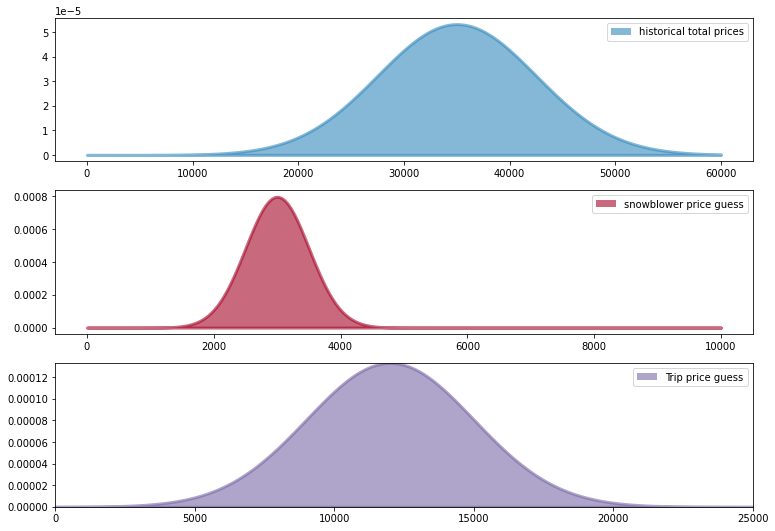

In [1]:
# A look at using pymc for doing Bayes in Python

# Based on Pilon (2017)
!pip install pymc
%matplotlib inline
import scipy.stats as stats                    # used for normal dist
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm                               # used for creating MC / Bayes estimate 
import scipy.optimize as sop                    # used for finding minimum - optimization function

figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500),
                       color="#348ABD", lw=3, alpha=0.6,
                       label="historical total prices")
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500),
                       color="#A60628", lw=3, alpha=0.6,
                       label="snowblower price guess")

p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                       color="#7A68A6", lw=3, alpha=0.6,
                       label="Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()]);

In [2]:
data_mu = [3e3, 12e3]

data_std = [5e2, 3e3]

mu_prior = 35e3
std_prior = 75e2

true_price = pm.Normal("true_price", mu_prior, 1.0 / std_prior ** 2)


prize_1 = pm.Normal("first_prize", data_mu[0], 1.0 / data_std[0] ** 2)
prize_2 = pm.Normal("second_prize", data_mu[1], 1.0 / data_std[1] ** 2)
price_estimate = prize_1 + prize_2


@pm.potential
def error(true_price=true_price, price_estimate=price_estimate):
        return pm.normal_like(true_price, price_estimate, 1 / (3e3) ** 2)


mcmc = pm.MCMC([true_price, prize_1, prize_2, price_estimate, error])
mcmc.sample(100000, 10000)

price_trace = mcmc.trace("true_price")[:]

 [-----------------100%-----------------] 100000 of 100000 complete in 13.8 sec

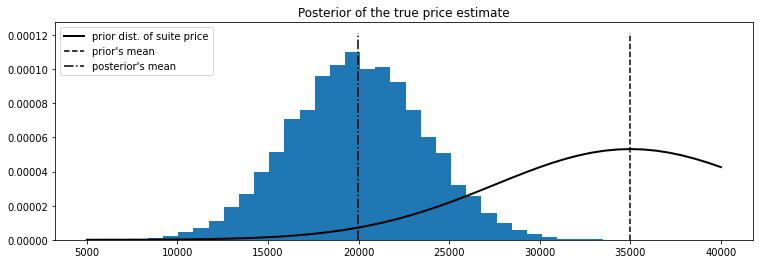

In [3]:
figsize(12.5, 4)


x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c="k", lw=2,
         label="prior dist. of suite price")

_hist = plt.hist(price_trace, bins=35, density=True, histtype="stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1 * np.max(_hist[0]), label="prior's mean",
           linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1 * np.max(_hist[0]),
           label="posterior's mean", linestyles="-.")
plt.legend(loc="upper left");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wi

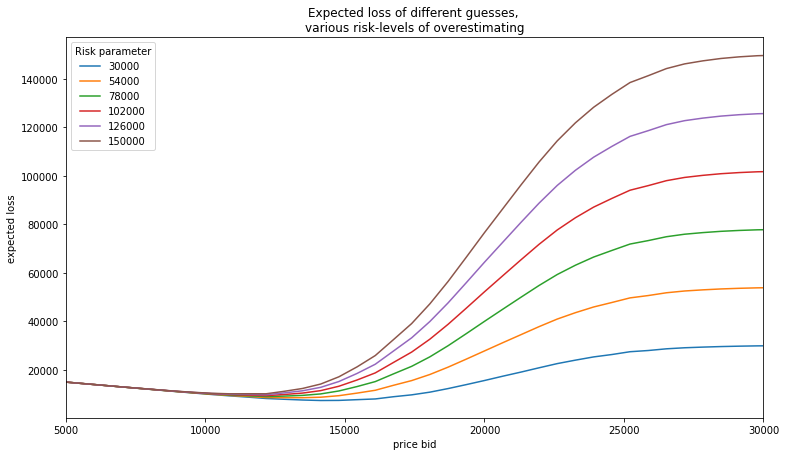

In [4]:
figsize(12.5, 7)
# numpy friendly showdown_loss


def showdown_loss(guess, true_price, risk=80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = [abs(true_price - guess) <= 250]
        loss[close_mask] = -2 * true_price[close_mask]
        loss[ix] = risk
        return loss


guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label="%d" % _p)

plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


minimum at risk 30000: 13990.82
minimum at risk 54000: 12635.64
minimum at risk 78000: 12199.34


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


minimum at risk 102000: 12167.74
minimum at risk 126000: 12109.02


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


minimum at risk 150000: 11133.42


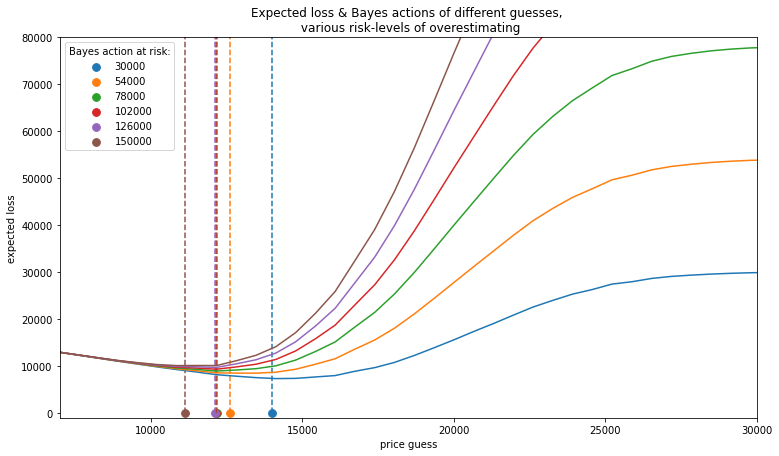

In [5]:
ax = plt.subplot(111)


for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,),disp = False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results , color = _color['color'])
    plt.scatter(_min_results, 0, s = 60, \
                color= _color['color'], label = "%d"%_p)
    plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))

plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints=1, title="Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);

# Bayes Classification Analysis with Text Data 

## Taken in Part from Learning Python Handbook

In [6]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [7]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics','rec.sport.baseball','rec.sport.hockey','rec.autos']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [8]:
print(train.data[5])

From: gballent@hudson.UVic.CA (Greg  Ballentine)
Subject: Re: Plus minus stat...
Nntp-Posting-Host: hudson.uvic.ca
Reply-To: gballent@hudson.UVic.CA
Organization: University of Victoria, Victoria, BC, Canada
Lines: 33


In article 1443@ramsey.cs.laurentian.ca, maynard@ramsey.cs.laurentian.ca (Roger Maynard) writes:

>Certainly pluggers are an integral part of any team.  And that is
>simply because there are not enough solid two-way players to go 
>around.  Who would you rather have as your "checking" centre?  Doug
>Gilmour or Doug Jarvis?  For that matter I would take either Gretzky
>or Mario as my "checking" centres.  Do you think Gretzky could cover
>Bob Gainey? 

Gretzky, Lemieux, Gilmour etc do not play the role of checking centreman.
They play an offensive role as opposed to a defensive one.  If they
were used as defensive centres it would be a waste of their offensive
abilities. 

When you compare Gretzky et al to Jarvis, Gainey etc you are comparing 
apples and oranges.  It is l

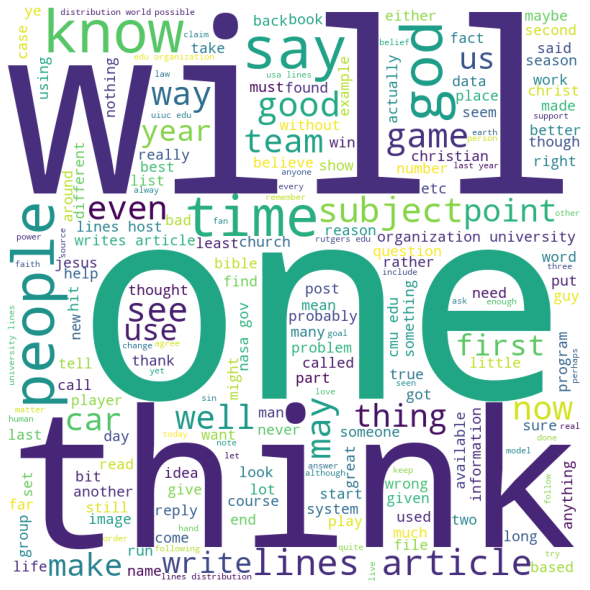

In [29]:
from wordcloud import WordCloud, STOPWORDS 
import nltk
from nltk.corpus import stopwords
comment_words = '' 
custom_stopwords = ["go", "going",'re','posting','nntp','posting']
stopwords = set(STOPWORDS).union(custom_stopwords) 

# iterate through the csv file 
for val in train.data: 
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [10]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

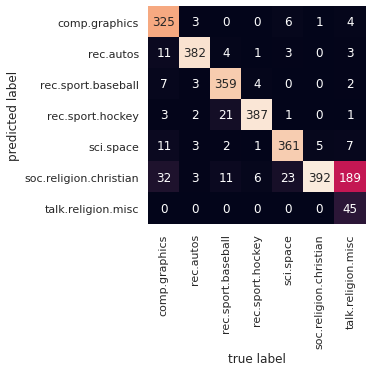

In [11]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Weighted and Macro Multiclass Confusion Matrix 

In [12]:
from sklearn import metrics

print(metrics.confusion_matrix(test.target, labels))

print(metrics.classification_report(test.target, labels)) # Religion seems to be the tricky one to classify 

[[325  11   7   3  11  32   0]
 [  3 382   3   2   3   3   0]
 [  0   4 359  21   2  11   0]
 [  0   1   4 387   1   6   0]
 [  6   3   0   1 361  23   0]
 [  1   0   0   0   5 392   0]
 [  4   3   2   1   7 189  45]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       389
           1       0.95      0.96      0.96       396
           2       0.96      0.90      0.93       397
           3       0.93      0.97      0.95       399
           4       0.93      0.92      0.92       394
           5       0.60      0.98      0.74       398
           6       1.00      0.18      0.30       251

    accuracy                           0.86      2624
   macro avg       0.90      0.82      0.81      2624
weighted avg       0.90      0.86      0.84      2624



In [13]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [14]:
predict_category('sending a payload to the ISS')

'sci.space'

In [15]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [16]:
predict_category('determining the screen resolution')

'comp.graphics'

In [17]:
predict_category('great hit') #this would be a hard one

'rec.sport.baseball'

In [18]:
predict_category('shot the puck into the net')

'rec.sport.hockey'

# Potentially handy code to keep in mind

In [19]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [20]:
confusion_metrics(mat)

True Positives: 382
True Negatives: 325
False Positives: 11
False Negatives: 3
--------------------------------------------------
Accuracy: 0.98
Mis-Classification: 0.02
Sensitivity: 0.99
Specificity: 0.97
Precision: 0.97
f_1 Score: 0.98


In [21]:
def precision(y_true, y_pred):
    i = set(y_true).intersection(y_pred)
    len1 = len(y_pred)
    if len1 == 0:
        return 0
    else:
        return len(i) / len1


def recall(y_true, y_pred):
    i = set(y_true).intersection(y_pred)
    return len(i) / len(y_true)


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    if p + r == 0:
        return 0
    else:
        return 2 * (p * r) / (p + r)


if __name__ == '__main__':
    print(f1(['A', 'B', 'C'], ['A', 'B']))

0.8


In [22]:
# The codes below is partly copied from the code written by Matt Brem, Global Instructor at General Assembly.
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)
# Instantiating a logisitic regression model
logreg = LogisiticRegression()
logreg.fit(X_train, y_train)    # model fitting
y_pred = logreg.predict(X_test)   # Predictions
# Calculating class probabilities
pred_proba = [i[1] for i in logreg.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
# The codes below is motly copied from the code written by Matt Brem, Global Instructor at General Assembly.
# Create figure.
plt.figure(figsize = (10,7))
# Create threshold values. 
thresholds = np.linspace(0, 1, 200)
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')
# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
# Label axes.
plt.title(f"ROC Curve with AUC = {round(metrics.roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
# Create legend.
plt.legend(fontsize=16);

NameError: ignored